In [2]:
from biometrics_engine import get_oura_data, datetime_to_string, string_to_datetime
from datetime import date
from datetime import datetime
from datetime import timedelta
from scipy.stats import norm
import pandas as pd
import numpy as np
import warnings
import matplotlib as mpl
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

start_date = "2021-12-13T07:50:57+00:00"
end_date = datetime_to_string(date.today())

In [3]:
raw_heart_data = get_oura_data(start_date,end_date,'heartrate')
raw_daily_data = get_oura_data(start_date,end_date,'daily_activity')
raw_workout_data = get_oura_data(start_date,end_date,'workout')

In [4]:
print(f"Heart data has {raw_heart_data.shape[0]} rows and {raw_heart_data.shape[1]} columns")
print(f"Daily data has {raw_daily_data.shape[0]} rows and {raw_daily_data.shape[1]} columns")
print(f"Workout data has {raw_workout_data.shape[0]} rows and {raw_workout_data.shape[1]} columns")

Heart data has 32224 rows and 4 columns
Daily data has 124 rows and 26 columns
Workout data has 29 rows and 10 columns


In [5]:
# keep raw loaded data spperate
heart_data = raw_heart_data
daily_data = raw_daily_data
workout_data = raw_workout_data

# configure indexes
heart_data = heart_data.set_index('timestamp',drop=True)
heart_data = heart_data.reset_index().drop(['index'],axis='columns')
daily_data = daily_data.set_index('timestamp',drop=True)
daily_data = daily_data.reset_index()

# configure datetime
def to_datetime(date_string):
    return datetime.strptime(date_string, '%Y-%m-%dT%H:%M:%S')

heart_data['timestamp'] = heart_data['timestamp'].str.slice(0,19)
heart_data['date'] = heart_data['timestamp'].str.slice(0,10).astype("datetime64")
heart_data['time'] = heart_data['timestamp'].str.slice(11,19)
heart_data['hour'] = heart_data['timestamp'].str.slice(11,13).astype(int)
heart_data['timestamp'] = heart_data['timestamp'].apply(to_datetime)

daily_data['date'] = daily_data['timestamp'].str.slice(0,10).astype("datetime64")
daily_data['time'] = daily_data['timestamp'].str.slice(11,19)
daily_data = daily_data.set_index('date')

# expand out the contributors json entry in daily data
contributors = pd.DataFrame(daily_data['contributors'].to_dict()).transpose()
daily_data = daily_data.merge(contributors,left_index=True,right_index=True).drop(['contributors'],'columns')

In [6]:
#extract the class_5_min attribute and unpivot to get a lookup table for activity class
class_5_min = pd.DataFrame([list(r) for r in daily_data['class_5_min'].tolist()],index=daily_data.index)
class_5_min.index.tolist()[0].to_pydatetime()
class_unpivot = class_5_min.melt(value_vars=class_5_min.columns,var_name="5_min",value_name="activity_class", ignore_index=False)
class_unpivot['hr'] = (class_unpivot['5_min'] / 12).astype(int).astype(str).str.zfill(2)
class_unpivot['min'] = ((class_unpivot['5_min'] % 12)*5).astype(int).astype(str).str.zfill(2)
class_unpivot['start_timestamp'] = class_unpivot.index.astype(str) + "T" + class_unpivot['hr'] + ":" + class_unpivot['min']
class_unpivot['start_timestamp'] = pd.to_datetime(class_unpivot['start_timestamp'])
class_unpivot['end_timestamp'] = pd.to_datetime(class_unpivot['start_timestamp']) + timedelta(minutes=5)
activity_class = class_unpivot.reset_index().drop(['date','5_min','hr','min'], axis='columns')
activity_class = activity_class.sort_values('start_timestamp').reset_index(drop=True)
activity_class.head()

activity_class     start_timestamp       end_timestamp
0              1 2021-12-14 00:00:00 2021-12-14 00:05:00
1              1 2021-12-14 00:05:00 2021-12-14 00:10:00
2              1 2021-12-14 00:10:00 2021-12-14 00:15:00
3              1 2021-12-14 00:15:00 2021-12-14 00:20:00
4              1 2021-12-14 00:20:00 2021-12-14 00:25:00

In [7]:
#check for duplicate timestamps
activity_class['start_timestamp'].is_unique and activity_class['end_timestamp'].is_unique

True

In [8]:
activity_names = {
    0 : "non wear",
    1 : "rest",
    2 : "inactive",
    3 : "low activity",
    4 : "medium activity",
    5 : "high activity"
}

def activity_lookup(timestamp,lookup_table=activity_class):
    try:
        return int(lookup_table[
            (lookup_table['start_timestamp'] <= timestamp )
            &
            (lookup_table['end_timestamp'] > timestamp)
        ].reset_index(drop=True).loc[0,'activity_class'])
    except:
        None

def activity_name_lookup(x):
    try:
        return activity_names[int(x)]
    except:
        return None

heart_data['activity_num'] = heart_data['timestamp'].apply(activity_lookup)
heart_data['activity'] = heart_data['activity_num'].apply(activity_name_lookup)
heart_data['activity'].value_counts()

inactive           12683
rest               11854
low activity        6110
non wear            1105
medium activity      365
high activity          3
Name: activity, dtype: int64

In [9]:
heart_data

timestamp  bpm source       date      time  hour  \
0     2021-12-13 07:50:57   78  awake 2021-12-13  07:50:57     7   
1     2021-12-13 07:51:18   80  awake 2021-12-13  07:51:18     7   
2     2021-12-13 07:51:28   74  awake 2021-12-13  07:51:28     7   
3     2021-12-13 08:25:49   78  awake 2021-12-13  08:25:49     8   
4     2021-12-13 08:25:52   82  awake 2021-12-13  08:25:52     8   
...                   ...  ...    ...        ...       ...   ...   
32219 2022-04-15 14:25:29   72  awake 2022-04-15  14:25:29    14   
32220 2022-04-15 14:25:32   70  awake 2022-04-15  14:25:32    14   
32221 2022-04-16 00:11:30   74  awake 2022-04-16  00:11:30     0   
32222 2022-04-16 00:11:57   77  awake 2022-04-16  00:11:57     0   
32223 2022-04-16 00:12:05   70  awake 2022-04-16  00:12:05     0   

       activity_num  activity  
0               NaN      None  
1               NaN      None  
2               NaN      None  
3               NaN      None  
4               NaN      None  
...             ...       ...  
32219           2.0  inactive  
32220           2.0  inactive  
32221           1.0      rest  
32222           1.0      rest  
32223           1.0      rest  

[32224 rows x 8 columns]

In [10]:
# look for entries with no activity - all on day before first full day of use.
heart_data[heart_data['activity'].isna()]['date'].value_counts()

2021-12-13    104
Name: date, dtype: int64

In [11]:
# high activity records seem to be erroneous - only 3 records,all within 30 seconds
heart_data[heart_data['activity'] == 'high activity']

timestamp  bpm source       date      time  hour  \
32188 2022-04-15 11:34:14   79  awake 2022-04-15  11:34:14    11   
32189 2022-04-15 11:34:19   81  awake 2022-04-15  11:34:19    11   
32190 2022-04-15 11:34:48   84  awake 2022-04-15  11:34:48    11   

       activity_num       activity  
32188           5.0  high activity  
32189           5.0  high activity  
32190           5.0  high activity

In [12]:
# remove high activity and None activity records
# (107 records) from 32224 records (target 32117 records)
print(f"Target Size {32224 - 107}")
heart_data = heart_data[heart_data['activity'] != 'high activity']
heart_data = heart_data[~heart_data['activity'].isna()]
heart_data.shape

Target Size 32117


(32117, 8)

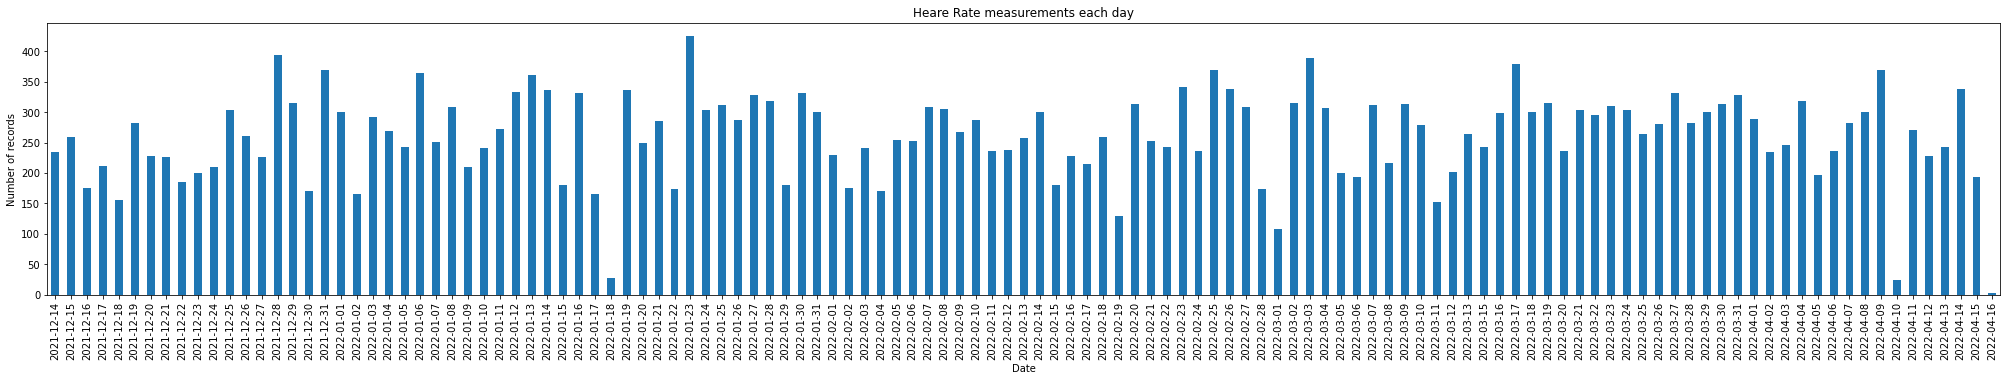

In [13]:
# how even are the heart rate measurements across dates?
ts = heart_data['timestamp']
ts.groupby(ts.dt.date).count().plot(kind='bar',figsize=(35,5))
plt.title("Heare Rate measurements each day")
plt.xlabel("Date")
plt.ylabel("Number of records")
plt.show()

In [14]:
# get weekday/weekend category
heart_data['day_name'] = heart_data['timestamp'].dt.day_name()
heart_data['is_weekday'] = (
    (heart_data['day_name'] != 'Saturday')
    &
    (heart_data['day_name'] != 'Sunday')
)
heart_data.head()

timestamp  bpm source       date      time  hour  activity_num  \
104 2021-12-14 00:00:13   75  awake 2021-12-14  00:00:13     0           1.0   
105 2021-12-14 00:00:17   83  awake 2021-12-14  00:00:17     0           1.0   
106 2021-12-14 00:00:18   80  awake 2021-12-14  00:00:18     0           1.0   
107 2021-12-14 00:05:15   69  awake 2021-12-14  00:05:15     0           1.0   
108 2021-12-14 00:05:16   64  awake 2021-12-14  00:05:16     0           1.0   

    activity day_name  is_weekday  
104     rest  Tuesday        True  
105     rest  Tuesday        True  
106     rest  Tuesday        True  
107     rest  Tuesday        True  
108     rest  Tuesday        True

In [15]:
fig, ax = plt.subplots(2,3,figsize=(15,7))

for x in range(2):
    for y in range(3):
        if (x,y) == (1,2):
            fig.delaxes(ax[x,y])
        else:
            i = 3 * x + y
            ax[x,y].hist(heart_data[
                (heart_data['activity'] == activity_names[i])
                &
                (heart_data['is_weekday'])
            ]['hour'],24, alpha=0.7, density=True)
            ax[x,y].hist(heart_data[
                (heart_data['activity'] == activity_names[i])
                &
                (~heart_data['is_weekday'])
            ]['hour'],24, alpha=0.7, density=True)
            ax[x,y].legend(['Weekday','Weekend'])
            ax[x,y].title.set_text(f"Distribution of {activity_names[i]} records ")
            ax[x,y].set_xlim([0,24])
            ax[x,y].set_yticklabels(['{:.0%}'.format(x) for x in ax[x,y].get_yticks()])
            plt.setp(ax[x,y], xlabel = "Hour in the day", ylabel = "Percentage of records")

fig.tight_layout()
plt.show()

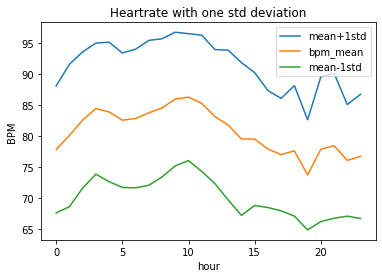

In [16]:
avg_rate_by_hr_m = heart_data[['hour','bpm']].groupby(['hour']).mean().round(2)
avg_rate_by_hr_s = heart_data[['hour','bpm']].groupby(['hour']).std().round(2)
avg_rate_by_hr = avg_rate_by_hr_m.merge(right=avg_rate_by_hr_s, on='hour', suffixes=("_mean","_std"))

avg_rate_by_hr["mean+1std"] = avg_rate_by_hr['bpm_mean'] + avg_rate_by_hr['bpm_std']
avg_rate_by_hr["mean-1std"] = avg_rate_by_hr['bpm_mean'] - avg_rate_by_hr['bpm_std']
avg_rate_by_hr.plot(y=['mean+1std','bpm_mean', 'mean-1std'])
plt.title("Heartrate with one std deviation")
plt.ylabel("BPM")
plt.show()

In [17]:
fig, ax1 = plt.subplots(4, 6, figsize=(20,10))
fig.suptitle("Comprison of Distribution of Heart Rate Records by Hour\n to a Gaussian approximation", fontsize=18)


#ax2 = ax1.twinx()
x_vals = np.linspace(heart_data['bpm'].min(),heart_data['bpm'].max(),200)
for r in range(4):
    for c in range(6):
        hr = 6 * r + c
        bpm_data = heart_data[heart_data['hour'] == hr]['bpm']
        max = bpm_data.max()
        ax1[r,c].hist(bpm_data, density=True,bins=40)
        ax1[r,c].plot(x_vals,norm.pdf(x_vals, loc=avg_rate_by_hr['bpm_mean'][hr], scale=avg_rate_by_hr['bpm_std'][hr]))
        plt.setp(ax1[r,c], title="Time: " + str(hr).zfill(2) + ":00 to " + str(hr+1).zfill(2) + ":00")
fig.tight_layout()
plt.show()

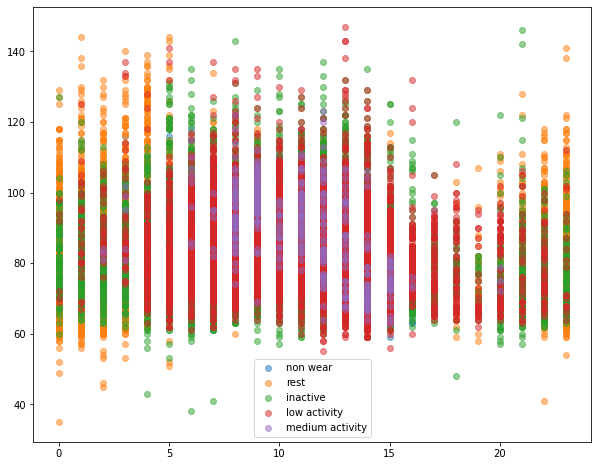

In [20]:
fig, ax = plt.subplots(1,1,figsize=(10,8))
for i in list(set(heart_data['activity_num'])):
    data = heart_data[heart_data['activity_num'] == i]
    ax.scatter(x=data['hour'], y=data['bpm'], alpha=0.5, label = activity_names[i])
plt.legend()    
plt.show()